In [89]:
#DNN with 100k events-2010 sqrt(s) = 7 TeV pp 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

In [90]:
# Load CSV file including 100k events
print("Loading dataset...")
df = pd.read_csv('/home/edaerdogan/Desktop/dimuonai/dimuon.csv')


Loading dataset...


In [91]:
#filtering and labeling 
signal_df = df[df['Q1'] * df['Q2'] < 0].copy()
background_df = df[df['Q1'] * df['Q2'] >= 0].copy() #df should stay unaffected, main purpose is to discriminate signal and background.

signal_df['target'] = 0
background_df['target'] = 1

filtered_df = pd.concat([signal_df, background_df], ignore_index=True) #pd.concat is a function used to concatenate DataFrames along a particular axis.


In [92]:
signal_count = len(df[df['Q1'] * df['Q2'] < 0]) #filters for signal and background in terms of charges
background_count = len(df[df['Q1'] * df['Q2'] >= 0])

total_signal = signal_count
total_background = background_count
total_events = total_signal + total_background

# Calculate percentages
signal_percentage = total_signal / total_events * 100
background_percentage = total_background / total_events * 100

print(f'Total Signal Events: {total_signal}')
print(f'Total Background Events: {total_background}')
print(f'Signal Percentage: {signal_percentage}%')
print(f'Background Percentage: {background_percentage}%')

Total Signal Events: 62214
Total Background Events: 37786
Signal Percentage: 62.214000000000006%
Background Percentage: 37.785999999999994%


In [93]:
features = filtered_df[['pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'Q1', 'Q2']] #Since M is given as a parameter for both the muons, it is not taken as a parameter
target = filtered_df['target']

In [94]:
# Split data into train and test sets %20-%80
train_data, test_data, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=42)


In [95]:
# Convert data to PyTorch tensors
train_data_tensor = torch.tensor(train_data.values, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)

train_target_tensor = torch.tensor(train_target.values, dtype=torch.float32)
test_target_tensor = torch.tensor(test_target.values, dtype=torch.float32)


In [96]:
# Custom dataset to read
class MuonDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


In [97]:
# DataLoader
print("Loading model...")
train_dataset = MuonDataset(train_data_tensor, train_target_tensor)
test_dataset = MuonDataset(test_data_tensor, test_target_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Loading model...


In [98]:
# DNN model: 8 nodes in input, 100-50-20 in hiddens, 1 for output. Relu and linear for first 4 layers, and sigmoid for output
class MuonDNN(nn.Module):
    def __init__(self):
        super(MuonDNN, self).__init__()

        self.hidden_layer1 = nn.Linear(8, 100) #input included here
        self.hidden_layer2 = nn.Linear(100, 50)
        self.hidden_layer3 = nn.Linear(50, 20)
        self.output_layer = nn.Linear(20, 1)

        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

        self.dropout = nn.Dropout(0.2)
        
        nn.init.normal_(self.hidden_layer1.weight)
        nn.init.normal_(self.hidden_layer2.weight)
        nn.init.normal_(self.hidden_layer3.weight)
        nn.init.normal_(self.output_layer.weight)

    def forward(self, x):
        x = self.activation(self.dropout(self.hidden_layer1(x)))
        x = self.activation(self.dropout(self.hidden_layer2(x)))
        x = self.activation(self.dropout(self.hidden_layer3(x)))
        x = self.output_activation(self.output_layer(x))
        return x


In [99]:
# Create an instance of the model
model = MuonDNN()

In [100]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [101]:
best_test_loss = float('inf')
#best_epoch = 0
patience = 5 #I used for early stopping, but can this be beneficial for further optimization?
params = {"batch_size": 128} #no additional parameters were given in the article, should I add anything else?


In [102]:
# Initialize counters for overall metrics
total_signal_predictions = []
total_signal_targets = []
total_background_predictions = []
total_background_targets = []

true_signal_data_values = [] #M values for signal 
invariant_mass_spectrum_true_signal_values = []
invariant_mass_spectrum_predicted_signal_values = [] #there might be some issues here

#predicted_signal_M_values = []


In [103]:
# Training 
print("Preparing Training")
batch_size = params["batch_size"]

num_epochs = 100
best_test_loss = float('inf')

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step() #update

Preparing Training


In [104]:
#true_signal_M_values = test_data_tensor[test_target_tensor.numpy() == 0][:, -1].numpy()  # Assuming M column is the last column

# Evaluate on the test set
with torch.no_grad():
        test_losses = []
        predictions = []

        for inputs, targets in test_loader:
            test_outputs = model(inputs)
            test_loss = criterion(test_outputs, targets.view(-1, 1))
            test_losses.append(test_loss.item())
            predictions.extend(test_outputs.round().detach().numpy())

            #binary_predictions = (test_outputs >= 0.5).float() # not sure if this should be beneficial
            #predictions.extend(binary_predictions.cpu().numpy()) 

# Accumulate predictions and targets for overall metrics calculation
total_signal_targets.extend(targets.numpy())
total_background_targets.extend((1 - targets).numpy())

total_signal_predictions.extend(test_outputs.round().detach().numpy())
total_background_predictions.extend((1 - test_outputs.round().detach().numpy()))


/home/edaerdogan/anaconda3/envs/aienv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


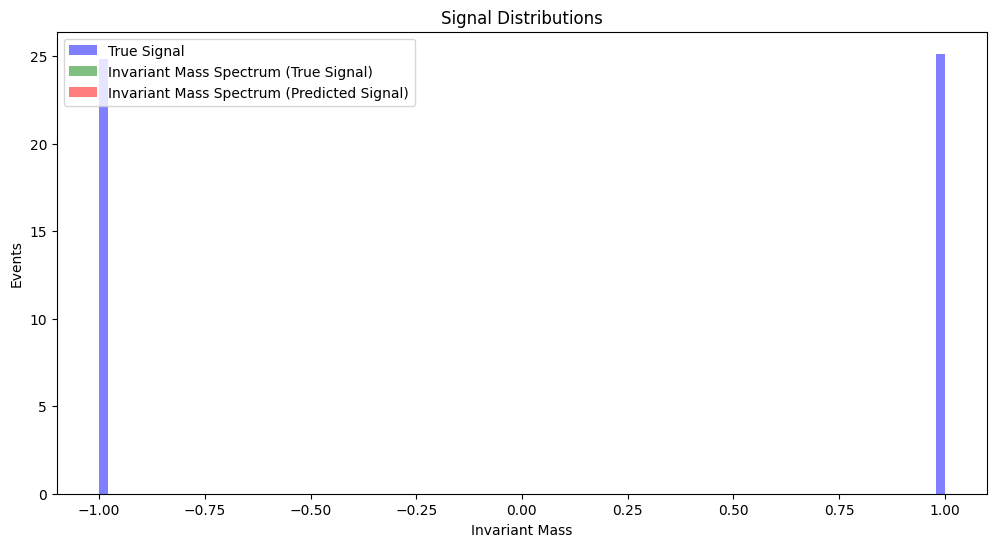

In [105]:
# Collect data for histograms
true_signal_data_values.extend(test_data_tensor[test_target_tensor.numpy() == 0][:, 7].numpy())#I am supposed to take the 20th column for M values but dimensions do not match error occurs 
#test data set;mu-mu+spectrum; predicted mu-mu+ spectrum
true_signal_indices = [i for i, target in enumerate(test_target_tensor.numpy()) if target == 0]
true_signal_data = test_data_tensor[true_signal_indices] 

#invariant_mass_spectrum_true_signal_values.extend(torch.sum(true_signal_data, dim=1).numpy())

threshold = 0.5
predicted_signal_indices = [i for i, pred in enumerate(predictions) if pred > threshold]
predicted_signal_data = test_data_tensor[predicted_signal_indices]
#invariant_mass_spectrum_predicted_signal_values.extend(torch.sum(predicted_signal_data, dim=1).numpy())

# Draw histograms after each epoch
plt.figure(figsize=(12, 6))

# Histogram for True Signal
plt.hist(true_signal_data_values, bins=100, color='blue', alpha=0.5, label='True Signal', density=True)

# Histogram for Invariant Mass Spectrum of True Signal
plt.hist(invariant_mass_spectrum_true_signal_values, bins=100, color='green', alpha=0.5, label='Invariant Mass Spectrum (True Signal)', density=True)

# Histogram for Invariant Mass Spectrum of Predicted Signal
plt.hist(invariant_mass_spectrum_predicted_signal_values, bins=50, color='red', alpha=0.5, label='Invariant Mass Spectrum (Predicted Signal)', density=True)

plt.title('Signal Distributions')
plt.xlabel('Invariant Mass')
plt.ylabel('Events')
plt.legend()
plt.show()



In [106]:
# Early stopping
average_test_loss = np.mean(test_losses)

if average_test_loss < best_test_loss:
    best_test_loss = average_test_loss 
    best_epoch = epoch
elif epoch - best_epoch >= patience:
    print(f'Early stopping at epoch {epoch + 1}. Best test loss: {best_test_loss}')

In [107]:
#TP, FN, FP, TN; bu değerler makaledekine epey yakın çıkıyor 

# Converting arrays to binary labels (0 and 1)
total_targets = (np.concatenate([total_signal_targets, total_background_targets])) 
total_predictions = (np.concatenate([total_signal_predictions, total_background_predictions]))

# Confusion matrix
conf_matrix = confusion_matrix(total_targets, total_predictions)

# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[21 11]
 [11 21]]
